In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(0)

## First attempt at a linear model

In [16]:
# Make up some data for regression
X, y = make_regression(n_samples = 20, n_features = 1, noise = 3.0, bias = 100.0)

In [17]:
X[0:5]

array([[-0.15135721],
       [ 0.40015721],
       [ 0.97873798],
       [-0.85409574],
       [-0.97727788]])

In [18]:
y[0:5]

array([  97.97233911,  107.77808686,  109.34004068,   89.67546479,
         90.53357417])

In [19]:
# Generate significant outliers
X_outliers = np.random.normal(0, 0.5, size = (4,1))
y_outliers = np.random.normal(0, 2.0, size = 4)

X_outliers[:2, :] += X.max() + X.mean() / 4.
X_outliers[2:, : ] += X.min() - X.mean() / 4.

y_outliers[:2] += y.min() - y.mean() / 4.
y_outliers[2:] += y.max() + y.mean() / 4.

# add outliers to existing data
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))

In [20]:
X[0:5]

array([[-0.15135721],
       [ 0.40015721],
       [ 0.97873798],
       [-0.85409574],
       [-0.97727788]])

In [21]:
y[0:5]

array([  97.97233911,  107.77808686,  109.34004068,   89.67546479,
         90.53357417])

Let's visually confirm any suspicions about the dataset. We should see some outliers that we just placed. 

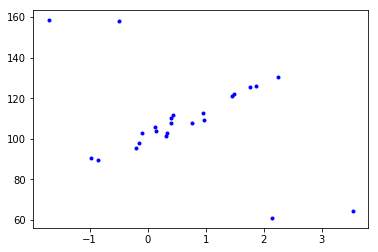

In [22]:
plt.plot(X, y, 'b.')
plt.show()

Great, there are outliers now. 4 in total. Upper left and lower right. Now, let's attempt to fit a model against this data. We'll do it first WITHOUT outlier reduction

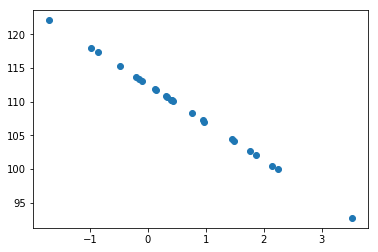

In [24]:
# fit model and predict WITHOUT outlier reduction
raw_model = Ridge().fit(X, y)
y_pred = raw_model.predict(X)

# plot results
plt.scatter(X, y_pred)
plt.show()

Something is wrong with this model. The outliers are clearly messing up the model. The high variance outliers are causing a strong overfitting in the model. That's why it's producing a negative slope model for a positive slop trend. 

## Reduce overfitting with EllipticEnvelope

One method of outlier reduction is to fit an EllipticEnvelope to the data and use its predict() method to detect and retain only those data points which are "inliers"

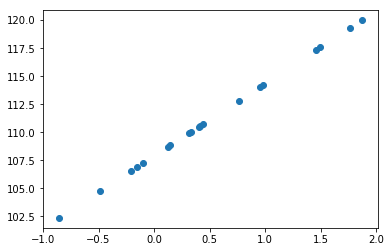

In [25]:
def elliptic_envelope_session():
    # fit the envelope
    envelope = EllipticEnvelope(support_fraction = 1, contamination = 0.2).fit(X, y)
    
    # Create a boolean indexing array to pick up outliers
    outliers = envelope.predict(X) == -1 
    
    # re-slice X, y into a clean dataset with outliers excluded
    X_clean = X[~outliers]
    y_clean = y[~outliers]
    return X_clean, y_clean

def fit_plot(dataset_clean):
    # unpack the clean dataset
    X_clean, y_clean = dataset_clean
    
    # Assuming we have our set of inliers in X_clean, we can re-fit now
    model = Ridge().fit(X_clean, y_clean)
    y_pred = model.predict(X_clean)
    
    # plot the regression
    plt.scatter(X_clean, y_pred)
    plt.show()
    
fit_plot(elliptic_envelope_session())

This looks much better. It did a good job of sequesting the outliers.

## Alternatives to the EllipticEnvelope - KMean, LocalOutlierFactor

In [45]:
def kmeans_session():
    # run k-means clustering
    km_clusters = KMeans(n_clusters = 3, algorithm = "full").fit_predict(X, y)
    
    # create cluster distribution...this time they are in tuples so we can sort easily
    dist_clusters = ((np.sum(km_clusters == z), z) for z in np.unique(km_clusters))
    
    # sort clusters descendingly by number of data entries in cluster
    dist_clusters = sorted(dist_clusters, reverse = True)
    
    print(dist_clusters)
    
    # find out the cluster with max number of data entries
    max_cluster = dist_clusters[0][1]
    
    # select data in max_cluster as inliers
    inliers = km_clusters == max_cluster
    
    return X[inliers], y[inliers]

[(13, 1), (7, 0), (4, 2)]


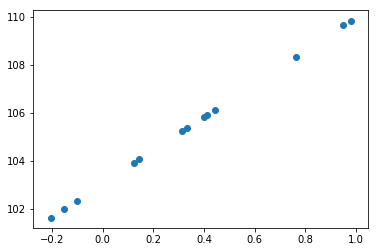

In [46]:
fit_plot(kmeans_session())

## LocalOutlierFactor

In [33]:
def local_outlier_factor_session():
    lof_labels = LocalOutlierFactor(n_neighbors = 10).fit_predict(X, y)
    inliers = lof_labels == 1 # select inliers
    return X[inliers], y[inliers]

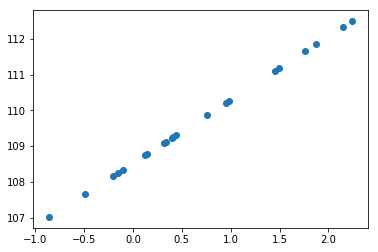

In [34]:
fit_plot(local_outlier_factor_session())